<a href="https://colab.research.google.com/github/aim56009/python_project/blob/master/githubversion_of_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time

%matplotlib inline

# Define the Model

In [ ]:
def generator(hidden_layers=1,hidden_units=100,output_units=784):
    '''generator network'''
    model = tf.keras.Sequential()                                               #Sequential groups a linear stack of layers into a tf.keras.Model.
    for i in range(hidden_layers):                                              #adds as much hidden layers as I want it to
        model.add(tf.keras.layers.Dense(units=hidden_units, use_bias=False))
        model.add(tf.keras.layers.LeakyReLU())                                  # activation fct: LeakyReLU
        
    model.add(tf.keras.layers.Dense(units=output_units, activation='tanh'))     #output activion: tanh
    return model

def discriminator(hidden_layers=1,hidden_units=100,output_units=1):
    '''discriminator network'''
    model = tf.keras.Sequential()
    for i in range(hidden_layers):
        model.add(tf.keras.layers.Dense(units=hidden_units))                
        model.add(tf.keras.layers.LeakyReLU())                                  # activiation: LeakyRelu
        model.add(tf.keras.layers.Dropout(rate=0.5))                            # with dropout
        
    model.add(tf.keras.layers.Dense(units=output_units,activation=None))        # output layer with linear activation (sigmoid activation will be added in the Binary_crossentropy loss later)
    return model

# Define the Data preprocessing steps

In [ ]:
mnist_b = tfds.builder('mnist')                                                 #TFDS provides a collection of ready-to-use datasets for use with TensorFlow
mnist_b.download_and_prepare()
mnist = mnist_b.as_dataset(shuffle_files=False)                                 #shuflle_files=False: no shuffling between epochs


                                                                                #from keras API :
                                                                                #builder = tfds.builder('mnist')
                                                                                # 1. Create the tfrecord files (no-op if already exists)
                                                                                #builder.download_and_prepare()
                                                                                # 2. Load the `tf.data.Dataset`
                                                                                #ds = builder.as_dataset(split='train', shuffle_files=True)

def preprocess(example):
    img = example['image']
    img = tf.image.convert_image_dtype(img, tf.float32)                         # converts image to type tf.float32
    img = tf.reshape(img, [-1])                                                 #reshape (,[-1]) reshapes it into a 1.D array 
    img = img*2 - 1.0                                                           # converts values from [0,1] to [-1, 1]
    z_in = tf.random.normal(shape=(z_size,))                                    #initialzes a rndm normally distributed vector of size z_size
    
    return z_in, img                                                            #z_in is the input fo the generator and image the input for the discriminator

# Seting up the Model

##### Set the Parameters

In [ ]:
epochs = 150       #150

batch_size = 64
image_size = (28, 28)
z_size = 20
gen_hidden_layers = 5    #3
gen_hidden_size = 100
disc_hidden_layers = 5  #3
disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)

fixed_z = tf.random.normal(shape=(batch_size, z_size))                          # will be used as the input of the generator

##### Create the samples for plotting later on

In [ ]:
def create_samples(g_model, z_in):                                              # samples that the generator creates (want to observe them later)
    g_output = g_model(z_in, training=False)                                    # output of generator corresponds to pixels (but all alined in a 1D-array)
    images = tf.reshape(g_output, (batch_size, *image_size))                    # reshapes pixels back to square form (batchsize, 28, 28) ,  star allows varying number of image_size
    return (images+1)/2.0                                                       # transforms back to [0,1] pixel values

##### Prepare the dataset

In [ ]:
mnist_train = mnist['train']                                                    # initialise training set
mnist_train = mnist_train.map(preprocess)                                       # perform preprocessing on all images

mnist_train = mnist_train.shuffle(10000)                                        #Instead of shuffling the entire dataset, it maintains a buffer of buffer_size elements, and randomly selects the next element from that buffer (replacing it with the next input element, if one is available).
                                                                                #Changing the value of buffer_size affects how uniform the shuffling is: if buffer_size is greater than the number of elements in the dataset, you get a uniform shuffle; if it is 1 then you get no shuffling at all. 

mnist_train = mnist_train.batch(batch_size, drop_remainder=True)                #cCombines consecutive elements of the dataset into batches, drops elements that are not included in a mulitple of batch_size

##### Prepare the model

In [ ]:
gen_model = generator(hidden_layers=gen_hidden_layers, hidden_units=gen_hidden_size,output_units=np.prod(image_size))               # initialise the generator  np.prod converts image_size=(28,28) to 28*28
gen_model.build(input_shape=(None, z_size))                                                                                         # initialise the model and give shape of input 

disc_model = discriminator(hidden_layers=disc_hidden_layers, hidden_units=disc_hidden_size)                                         # initialise the discriminator
disc_model.build(input_shape=(None, np.prod(image_size)))                                                                           

##### Initialise the loss function and the optimizers:


In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)                  # define the loss function... for simple GAN's thats the BinaryCrossentropy...logits=True: applies sigmoid on inputs
gen_optimizer = tf.keras.optimizers.Adam()                                      # set up the optimizers
dis_optimizer = tf.keras.optimizers.Adam()                                      # https://keras.io/api/optimizers/

# The learning Process

I implement the minmax loss function as a traditional binary classification problem with labels 0 for generated and 1 for real images. \\
The model is fit seeking to minimize the average binary cross entropy, also called log loss.

    minimize [ y_true * -log(y_predicted) + (1 – y_true) * -log(1 – y_predicted) ]


In [ ]:
total_vals_dis = []
epoch_samples = []

start = time.time()                                                             # for measuring computation time
for epoch in range(1, epochs+1):
    epoch_vals_dis = []          
    for i,(input_z,input_real) in enumerate(mnist_train):                       # after preprocessing mnist_train consists of rndm input for generator and real input for discriminator
        
        # Compute the loss of the generator
        with tf.GradientTape() as gen_tape:                                     # start recording operations
            gen_output = gen_model(input_z)                                     # output of generator
            dis_pred_fake = disc_model(gen_output, training=True)               # output of discriminator after classifing fake/generator images
            labels_real = tf.ones_like(dis_pred_fake)                           # true labels are all one....
            gen_loss = loss_fn(y_true=labels_real, y_pred=dis_pred_fake)        # calculates the loss of the generator...high loss if discriminator classifies alot of images as fake
            
        gen_grads = gen_tape.gradient(gen_loss, gen_model.trainable_variables)                                # caluclate the gradient of the loss wrt. the trainable variables of the gen_model
        gen_optimizer.apply_gradients(grads_and_vars=zip(gen_grads, gen_model.trainable_variables))           # apply the gradients to the optimizer, grads_and_vars = list of gradient and variable pairs
        


        # Compute the loss of the discriminator
        with tf.GradientTape() as dis_tape:
            dis_pred_real = disc_model(input_real, training=True)                     # output of discriminator after classifing real images

            dis_true_labels = tf.ones_like(dis_pred_real)                             # true labels are 1
            
            dis_real_loss = loss_fn(y_true=dis_true_labels, y_pred=dis_pred_real)     # loss of discriminator when classifying real images

            dis_pred_fake = disc_model(gen_output, training=True)                     # output of discriminator after classifing fake/generator images (same as above)
            dis_fake_labels = tf.zeros_like(dis_pred_fake)                            # ture labels are 0 

            dis_fake_loss = loss_fn(y_true=dis_fake_labels, y_pred=dis_pred_fake)     # loss of discriminator when classifying fake/generated images

            dis_loss = dis_real_loss + dis_fake_loss                                  # total loss = sum of fake_loss + real_loss

        
        dis_grads = dis_tape.gradient(dis_loss, disc_model.trainable_variables)                                   # Computes the gradients of d_loss
        dis_optimizer.apply_gradients(grads_and_vars=zip(dis_grads, disc_model.trainable_variables))              # apply the gradients to the optimizer


        
        
        dis_real_prob = tf.reduce_mean(tf.sigmoid(dis_pred_real))                     #reduce_mean: computes the mean of elements across dimensions of a tensor
        dis_fake_prob = tf.reduce_mean(tf.sigmoid(dis_pred_fake))                     #apply simoid to predicted output
        epoch_vals_dis.append((dis_real_prob.numpy(), dis_fake_prob.numpy()))         #we want to plot the average of both values over an epoch later on



    total_vals_dis.append(epoch_vals_dis)
    
    #print some infos about the learning process
    print('Epoch {:03d} | Time {:.2f} min | Discriminator prediction of real: {:.2f} %   Discriminator prediction of fake: {:.2f} %]'.format(epoch, (time.time()-start)/60, *list(np.mean(total_vals_dis[-1], axis=0))))
    
# maybe try plotting     dis_real_prob/ ( dis_real_prob + dis_fake_prob)
    epoch_samples.append(create_samples(gen_model, fixed_z).numpy())            # used later for plotting generated images

Epoch 001 | Time 0.70 min | Discriminator thinks real: 0.77 %   Discriminator thinks fake: 0.30 %]
Epoch 002 | Time 1.39 min | Discriminator thinks real: 0.61 %   Discriminator thinks fake: 0.40 %]
Epoch 003 | Time 2.09 min | Discriminator thinks real: 0.58 %   Discriminator thinks fake: 0.43 %]
Epoch 004 | Time 2.79 min | Discriminator thinks real: 0.58 %   Discriminator thinks fake: 0.44 %]
Epoch 005 | Time 3.49 min | Discriminator thinks real: 0.56 %   Discriminator thinks fake: 0.45 %]
Epoch 006 | Time 4.18 min | Discriminator thinks real: 0.57 %   Discriminator thinks fake: 0.44 %]
Epoch 007 | Time 4.89 min | Discriminator thinks real: 0.57 %   Discriminator thinks fake: 0.45 %]
Epoch 008 | Time 5.59 min | Discriminator thinks real: 0.53 %   Discriminator thinks fake: 0.47 %]
Epoch 009 | Time 6.29 min | Discriminator thinks real: 0.52 %   Discriminator thinks fake: 0.47 %]
Epoch 010 | Time 6.99 min | Discriminator thinks real: 0.53 %   Discriminator thinks fake: 0.46 %]
Epoch 011 

# Visualisation

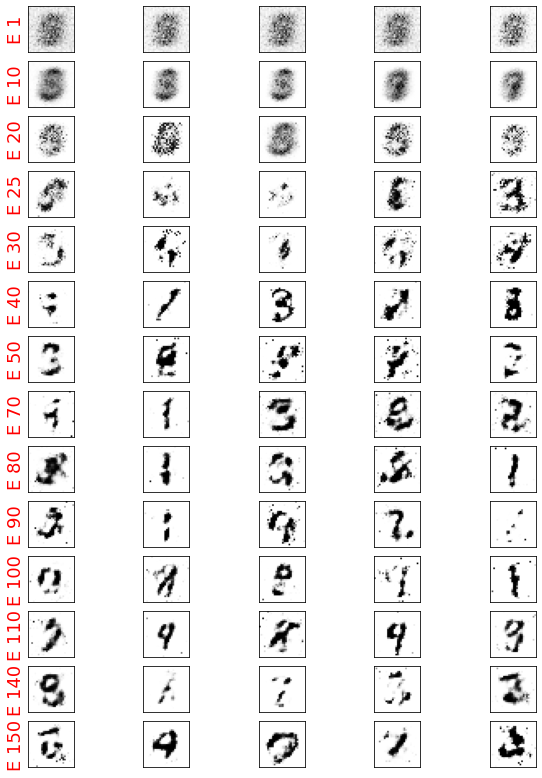

In [ ]:
selected_epochs = [1,10,20,25,30,40,50,70,80,90,100,110,140, 150]
fig = plt.figure(figsize=(10, 14))                  
for coun,epo in enumerate(selected_epochs):                                     
    for j in range(5):                                                          
        ax = fig.add_subplot(len(selected_epochs), 5, coun*5+j+1)
        ax.set_xticks([])
        ax.set_yticks([])
        if j == 0:
            ax.text(
                -0.06, 0.5, 'E {}'.format(epo),
                rotation=90, size=18, color='red',
                horizontalalignment='right',
                verticalalignment='center', 
                transform=ax.transAxes)
        
        image = epoch_samples[epo-1][j]
        ax.imshow(image, cmap='gray_r')
    
plt.show()

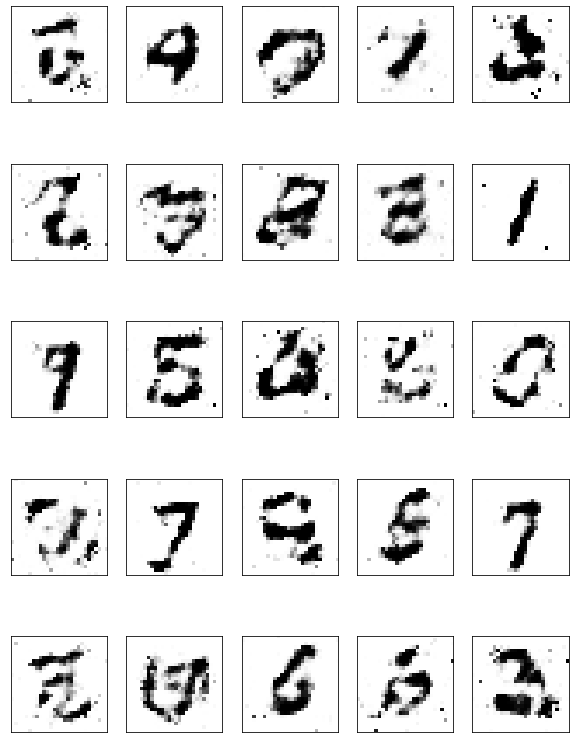

In [ ]:
li = [i for i in range(25)]


fig = plt.figure(figsize=(10, 14)) 

for i in li:                                                          
  plt.subplot(5, 5, li.index(i)+1)             
  plt.xticks([])
  plt.yticks([])
  image = epoch_samples[149][i]
  plt.imshow(image, cmap='gray_r')
    
plt.show()